In [1]:
# Install required libs
# !pip install -U segmentation-models-pytorch albumentations --user 

## Loading data

In [2]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt
from traversability_estimation.utils import visualize
from traversability_estimation.rellis_3d import DatasetSemSeg as Dataset

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [3]:
from torch.utils.data import DataLoader

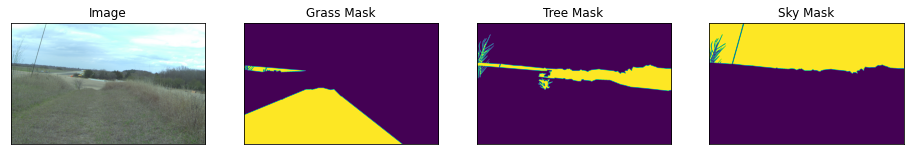

In [7]:
# Lets look at data we have

# dataset = Dataset(classes=['grass', 'tree', 'sky'], split='train')
# dataset = Dataset(classes=['grass', 'tree', 'sky'], split='val')
dataset = Dataset(classes=['grass', 'tree', 'sky'], split='test')

ind = int( np.random.choice(range(len(dataset))) )
image, mask = dataset[ind] # get some sample
visualize(
    image=image[..., (2,1,0)], 
    grass_mask=mask[..., 0],
    tree_mask=mask[..., 1],
    sky_mask=mask[..., 2]
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [9]:
src_size = np.array(image.shape[:2])
src_size

array([1200, 1920])

In [10]:
import albumentations as albu

size = (352, 640)  # src_size // 4

def get_training_augmentation():
    train_transform = [
        
        albu.Resize(size[0], size[1], interpolation=1, always_apply=True),  #cv2.INTER_LINEAR
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=size[0], min_width=size[1], always_apply=True, border_mode=0),
        # albu.RandomCrop(height=1200, width=1920, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(size[0], size[1], interpolation=1, always_apply=True) #cv2.INTER_LINEAR
    ]
    return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/home/ruslan/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


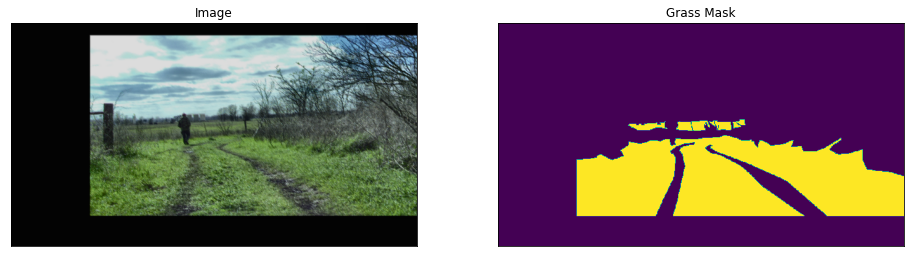

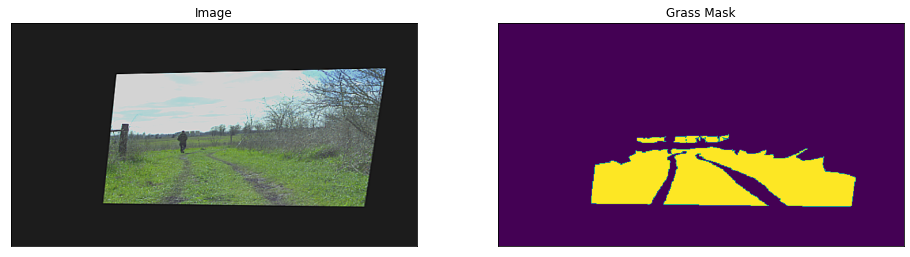

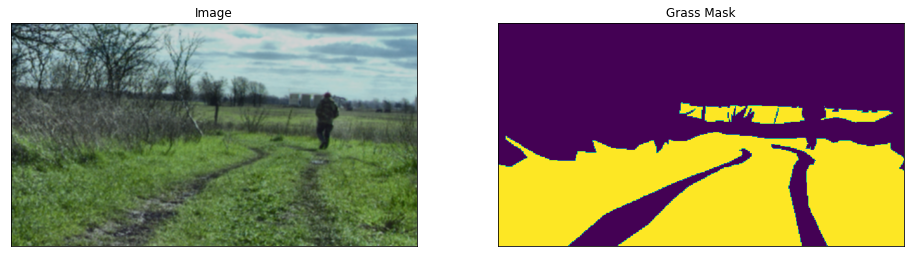

In [11]:
# Visualize resulted augmented images and masks

augmented_dataset = Dataset(augmentation=get_training_augmentation(), split='train')

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image[..., (2,1,0)], grass_mask=mask[..., 1])

## Create model and train

In [12]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [13]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['dirt', 'grass', 'tree', 'pole', 'water',
           'sky', 'vehicle', 'object', 'asphalt', 'building',
           'log', 'person', 'fence', 'bush', 'concrete',
           'barrier', 'puddle', 'mud', 'rubble']
ACTIVATION = 'sigmoid' if len(CLASSES) == 1 else 'softmax2d'  # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [14]:
train_dataset = Dataset(augmentation=get_training_augmentation(),
                        preprocessing=get_preprocessing(preprocessing_fn),
                        classes=CLASSES,
                        split='train')

valid_dataset = Dataset(augmentation=get_training_augmentation(),
                        preprocessing=get_preprocessing(preprocessing_fn),
                        classes=CLASSES,
                        split='val')

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/home/ruslan/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [15]:
len(train_dataset), len(valid_dataset)

(3302, 983)

In [16]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [26]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [18]:
# train model

max_score = 0
n_epochs = 10
for i in range(0, n_epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

## Test best saved model

In [14]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

## Visualize predictions

In [32]:
# test dataset without transformations for image visualization
test_dataset = valid_dataset

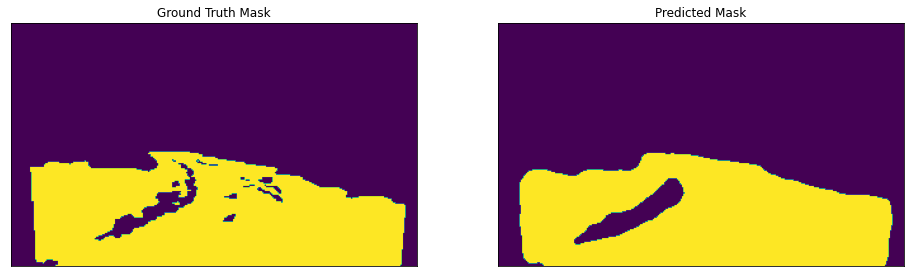

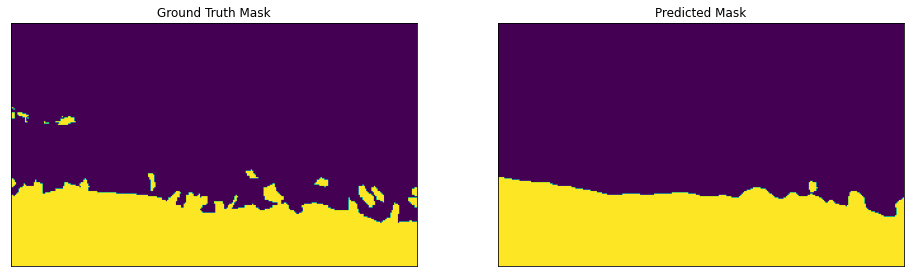

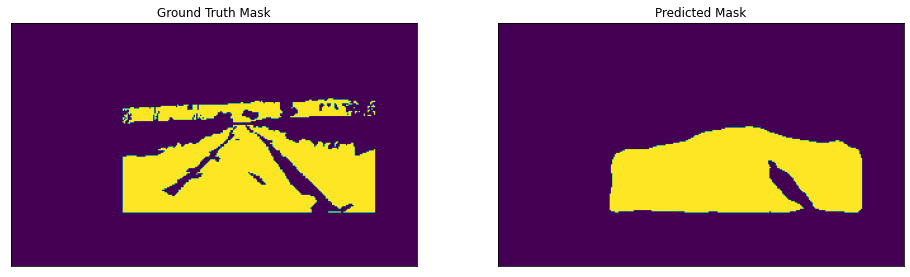

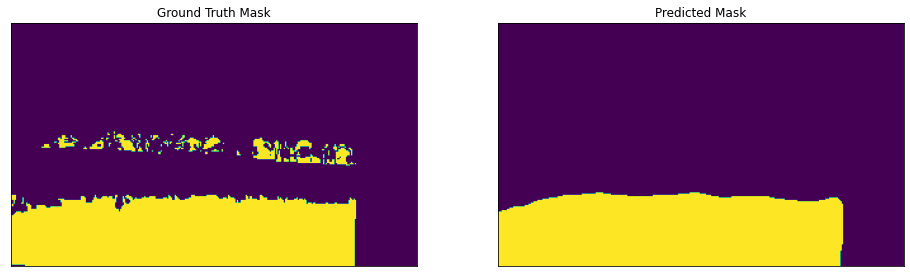

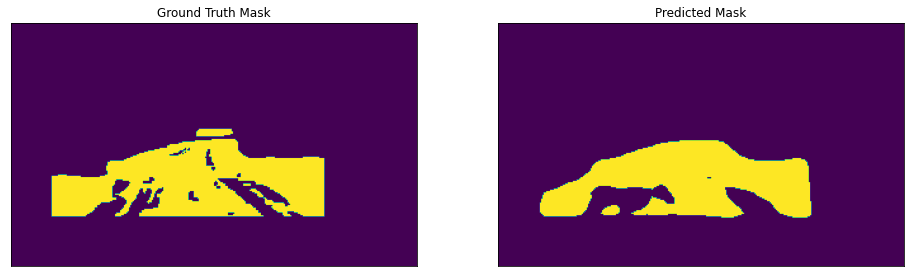

In [34]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        #image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )